# Goal
-----
Classify multivariate motion‑sensor sequences with a modern deep CNN (**InceptionTime**) using `sktime`, while explaining *what* each step does and *why* it matters.

Flow
-----
1. Install & import
2. Load **BasicMotions** (accelerometer + gyroscope)
3. Sanity‑check shapes and peek at raw signals
4. Plot a few sequences per activity to build intuition
5. Train **InceptionTimeClassifier** (why: multi‑scale pattern capture)
6. Evaluate with accuracy, per‑class report, and confusion matrix
7. Next steps: datasets, temporal CV, and tuning

Model in plain words
--------------------
* InceptionTime stacks 1‑D convolutions with **multiple kernel sizes** in parallel. This lets the model notice both *short blips* and *longer motifs* in the same layer.
* No hand‑crafted features needed — it learns from raw channels (accel_x/y/z, gyro_x/y/z).
* Works well when activities have **distinct temporal signatures** (e.g., running vs standing).

## Library

In [ ]:
# Install sktime (toolbox for time‑series, incl. deep models)
!pip install sktime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 13.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.datasets import load_basic_motions

## Data

In [ ]:
# BasicMotions: wearable sensor dataset with multiple activities.
# return_type='numpy3D' → arrays shaped as (n_samples, n_channels, n_timepoints)
X_train, y_train = load_basic_motions(split="train", return_X_y=True, return_type='numpy3D')
X_test, y_test = load_basic_motions(split="test", return_X_y=True, return_type='numpy3D')

In [ ]:
# The data was generated as part of a student project where four students performed four activities whilst wearing a smart watch.
# The watch collects 3D accelerometer and a 3D gyroscope.

# Shape:
# 40 samples
# Each sample has 6 features (accelerometer x, y, z and gyroscope x, y, z.)
# Each feature is a sequence of 100 time steps
print(X_train.shape)

(40, 6, 100)


In [ ]:
# Inspect one channel sequence from the first sample (e.g., channel 0)
# See raw magnitudes and time length so we know what the CNN will ingest
X_train[0][0]

array([ 3.940320e-01,  3.940320e-01, -3.666397e+00, -6.561010e-01,
        1.405135e+00,  2.220504e+00,  3.248704e+00,  3.020615e+00,
        1.957117e+00,  1.957117e+00, -1.956176e+00, -3.138694e+00,
       -2.905234e+00, -1.249818e+00, -1.249818e+00,  9.029840e-01,
        2.535184e+00,  2.947793e+00,  2.535360e+00,  1.058201e+00,
        9.782500e-02, -1.498574e+00, -1.912198e+00, -1.189464e+00,
        4.835800e-02,  1.049725e+00,  1.632314e+00,  1.497473e+00,
        7.729370e-01,  2.082210e-01, -1.244390e-01, -3.240370e-01,
       -4.404940e-01, -9.376000e-02,  2.721780e-01,  4.105780e-01,
        6.309900e-01,  3.040980e-01,  4.526310e-01,  5.536900e-02,
       -1.954260e-01, -1.080850e-01,  5.122000e-02,  4.950860e-01,
        5.824790e-01,  5.824790e-01,  5.353990e-01,  2.546730e-01,
        4.514700e-02,  1.266480e-01, -1.176300e-02, -6.780200e-02,
        6.254300e-02,  4.119100e-02,  2.925360e-01,  5.665930e-01,
        4.028800e-01, -9.530900e-02, -6.713820e-01, -2.991120e

In [ ]:
# Class labels present in the training set
# Check for class imbalance (not an issue here, but a good habit)
y_train

array(['standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'running', 'running', 'running', 'running', 'running', 'running',
       'running', 'running', 'running', 'running', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton'], dtype='<U9')

* We’ll pick four samples (different classes) and overlay their 6 sensor channels.
* Visual intuition makes later errors in the confusion matrix easier to reason about.

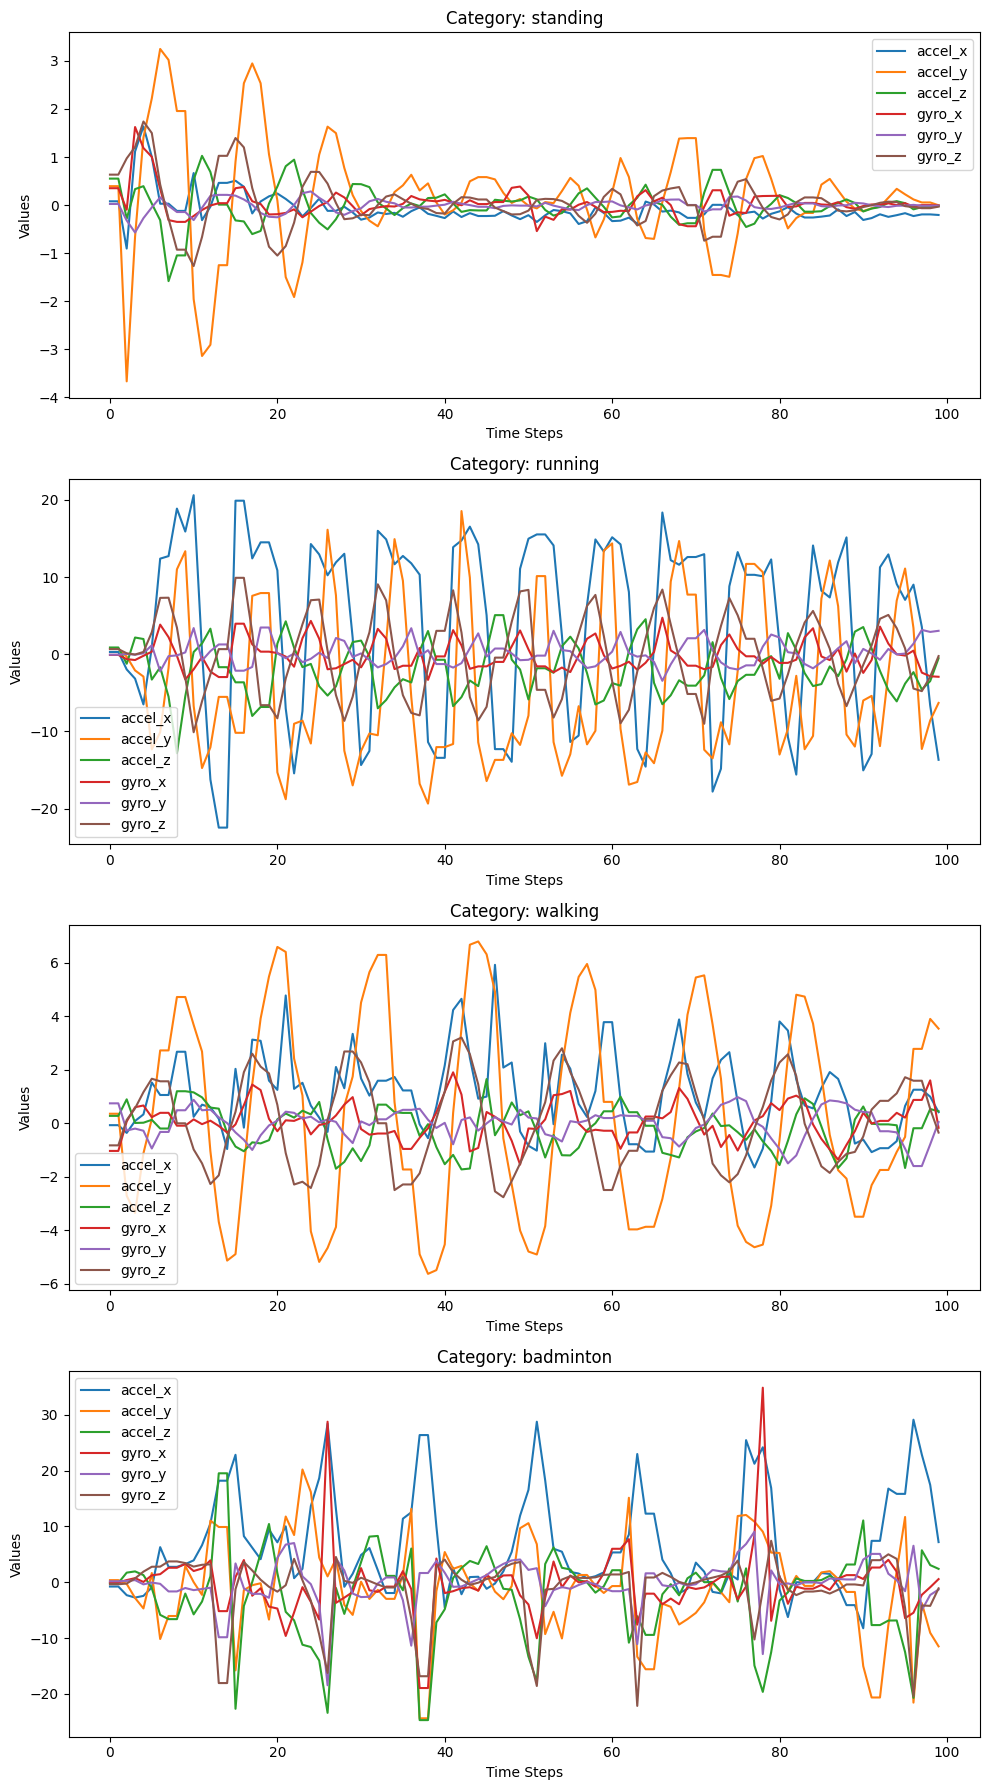

In [ ]:
# Plot the features for each sport
series_indices = [0, 10, 20, 30]
categories = ['standing', 'running', 'walking', 'badminton']
features = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]

# Slice the chosen samples (shape: len(series_indices), channels, time)
selected_series = X_train[series_indices]

fig, axes = plt.subplots(4, 1, figsize=(10, 18))

for i in range(4):
    for j in range(selected_series.shape[1]):
        # Plot each channel over time — InceptionTime will learn such local patterns
        axes[i].plot(selected_series[i, j], label=features[j])

    axes[i].set_title(f"Category: {categories[i]}")
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Values")
    axes[i].legend()

plt.tight_layout()
plt.show()

## Model

Why InceptionTime?
* Parallel 1‑D convs with different kernel sizes → multi‑scale feature capture
* Residual connections ease optimization of deep stacks
* Strong defaults: you can start without heavy preprocessing/feature engineering

In [ ]:
# https://www.sktime.net/en/v0.29.1/api_reference/auto_generated/sktime.classification.deep_learning.InceptionTimeClassifier.html
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Parameters to know (kept at your originals):
# * n_epochs=1500  → training passes; large here to converge fully (reduce for quick demos)
# * verbose=True   → show training logs
# Notes:
# * Other tunables you might explore later (not changed now):
#   - nb_filters (channels per conv): higher = more capacity
#   - kernel_size(s): controls temporal scale seen by each conv branch
#   - bottleneck_size: 1x1 conv compression for efficiency
#   - depth: number of inception blocks (network depth)
#   - dropout: regularization if you see overfitting
clf = InceptionTimeClassifier(n_epochs=1500, verbose=True)
clf.fit(X_train, y_train)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 100, 32)   │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 100, 6)    │          0 │ input_layer_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 100, 32)   │     40,960 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 100, 32)   │     20,480 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 100, 32)   │     10,240 │ conv1d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 100, 32)   │        192 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 100, 128)  │          0 │ conv1d_33[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_35[0][0],  │
│                     │                   │            │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ concatenate_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 100, 32)   │      4,096 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 100, 128)  │          0 │ activation_8[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 100, 32)   │     40,960 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 100, 32)   │     20,480 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 100, 32)   │     10,240 │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 100, 32)   │      4,096 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 100, 128)  │          0 │ conv1d_38[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_39[0][0],  │
│                     │                   │            │ conv1d_40[0][0],  │
│                     │                   │            │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ concatenate_7[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 100, 128)  │          0 │ batch_normalizat

 Total params: 493,188 (1.88 MB)

 Trainable params: 491,140 (1.87 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.0750 - loss: 1.4130 - learning_rate: 0.0010
Epoch 2/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.2746 - learning_rate: 0.0010
Epoch 3/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0949 - learning_rate: 0.0010
Epoch 4/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0368 - learning_rate: 0.0010
Epoch 5/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0193 - learning_rate: 0.0010
Epoch 6/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0121 - learning_rate: 0.0010
Epoch 7/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0081 - learning_rate: 0.0010
Epoch 8/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0055 - learning_rate: 0.0010
Epoch 9/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0039 - learning_rate: 0.0010
Epoch 10/1500
1/1 ━

InceptionTimeClassifier(verbose=True)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
predictions = clf.predict(X_test)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array(['standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'running', 'running', 'running', 'running', 'running', 'running',
       'running', 'running', 'running', 'running', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton'], dtype='<U9')

In [ ]:
# Accuracy gives an overall hit rate (macro‑averaged F1 in the report is often more informative on imbalanced sets)
print(clf.score(X_test, y_test))

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1.0
Accuracy: 1.0000


In [ ]:
# Print classification report
print(classification_report(y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

   badminton       1.00      1.00      1.00        10
     running       1.00      1.00      1.00        10
    standing       1.00      1.00      1.00        10
     walking       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



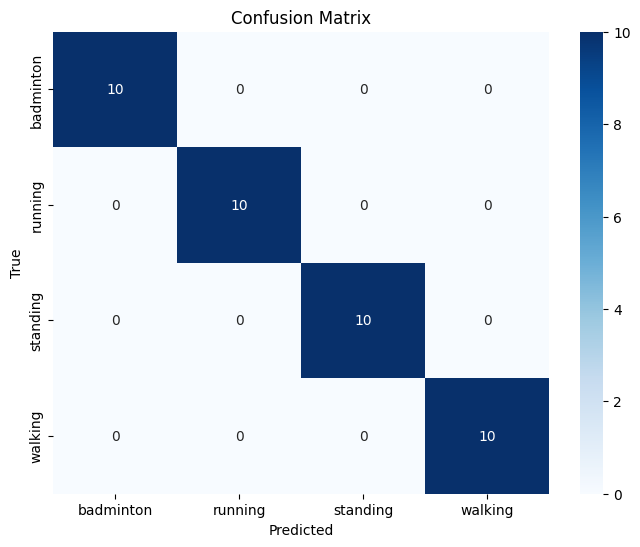

In [ ]:
# Confusion Matrix as a heatmap for quick error inspection
# Read me:
# * Diagonal = correct. Off‑diagonal = confusions (e.g., Running vs Walking)
# * If you see asymmetric errors, consider class‑specific augmentations or weighting.from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Next steps
-------------
* Try other datasets: `sktime.datasets` (e.g., ElectricDevices, TwoPatterns) to stress‑test generalization
* Do temporal cross‑validation on larger datasets (rolling origin) for robust estimates
* Tune InceptionTime: depth, nb_filters, kernel_sizes, bottleneck_size, dropout, n_epochs
* Consider data augmentation (time‑warp, jitter, scaling) for wearables to boost robustness
* Track training time and early‑stopping: large n_epochs can be pruned once validation stops improving